#  Anomaly Detection with Generative Adversarial Networks
https://arxiv.org/pdf/1703.05921

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training a DCGAN model with the target dataset

In [4]:
class ImageTransform():
    def __init__(self, mean, std, image_size):
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, image):
        return self.transform(image)

class TinyMnistDataset(Dataset):
    def __init__(self, root, train, keys, transform=None, download=True, num_images=200):
        self.dataset = datasets.MNIST(root=root, train=train, download=download)
        self.transform = transform

        self.indices = []
        for key in keys:
            key_indices = np.where(np.array(self.dataset.targets) == key)[0]
            self.indices += list(key_indices[:num_images])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, image_size):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1)  # Size([N, z_dim, 1, 1])
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z)
        z = self.last(z)                   # Size([N, 1, image_size, image_size])
        return z


class Discriminator(nn.Module):
    def __init__(self, z_dim, image_size):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        feature = torch.flatten(x, start_dim=1)

        x = self.last(x)
        return x, feature


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def build_GAN(z_dim=20, image_size=64):
    G = Generator(z_dim=z_dim, image_size=image_size).apply(weights_init)
    D = Discriminator(z_dim=z_dim, image_size=image_size).apply(weights_init)
    return G, D

In [6]:
def train(G, D,criterion, g_optimizer, d_optimizer, data_loader, device):
    G.train()
    D.train()

    total_g_loss = 0
    total_d_loss = 0
    for images in data_loader:
        images = images.to(device)
        batch_size = images.shape[0]

        # -----------------------
        # 1. Train Discriminator
        # -----------------------
        # Generate realness scores from real images.
        d_out_real, _ = D(images)

        # Generate realness scores from fake images.
        input_z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(input_z)
        d_out_fake, _ = D(fake_images)

        # Prepare labels.
        label_real = torch.full((batch_size,), 1, dtype=torch.float).to(device)
        label_fake = torch.full((batch_size,), 0, dtype=torch.float).to(device)

        # Calculate the loss.
        d_loss_real = criterion(d_out_real.view(-1), label_real)
        d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
        d_loss = d_loss_real + d_loss_fake

        # Backpropagate the loss and update the discriminator.
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # -----------------------
        # 2. Train Generator
        # -----------------------
        # Generate fake images from random noise.
        input_z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(input_z)
        d_out_fake, _ = D(fake_images)

        # Calculate the loss (This provides high loss when the discriminator see through fake images.)
        g_loss = criterion(d_out_fake.view(-1), label_real)

        # Backpropagate the loss and update the discriminator.
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    return total_g_loss / len(data_loader), total_d_loss / len(data_loader)


def train_GAN(G, D, criterion, g_optimizer, d_optimizer, data_loader, num_epochs):
    device = get_device()
    torch.backends.cudnn.benchmark = True

    G.to(device)
    D.to(device)
    for epoch in range(num_epochs):
        g_loss, d_loss = train(G, D, criterion, g_optimizer, d_optimizer, data_loader, device)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}')

In [7]:
MEAN = (0.5,)
STD = (0.5,)
image_size = 64
batch_size = 64

train_dataset = TinyMnistDataset(
    root=DATA_ROOT, train=True, keys=[7, 8], transform=ImageTransform(MEAN, STD, image_size))

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
num_epochs = 200
z_dim = 20
g_lr, d_lr = 0.0001, 0.0004
beta1, beta2 = 0.0, 0.9

G, D = build_GAN(z_dim=z_dim, image_size=image_size)

criterion = nn.BCEWithLogitsLoss(reduction='mean')
g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

train_GAN(G, D, criterion, g_optimizer, d_optimizer, train_dataloader, num_epochs)

Epoch [10/200], g_loss: 4.5718, d_loss: 0.0287
Epoch [20/200], g_loss: 2.2813, d_loss: 1.1358
Epoch [30/200], g_loss: 1.6978, d_loss: 0.9610
Epoch [40/200], g_loss: 1.2295, d_loss: 1.0594
Epoch [50/200], g_loss: 1.3216, d_loss: 1.1359
Epoch [60/200], g_loss: 1.2738, d_loss: 0.9377
Epoch [70/200], g_loss: 1.5734, d_loss: 0.9352
Epoch [80/200], g_loss: 1.6710, d_loss: 0.8515
Epoch [90/200], g_loss: 1.7691, d_loss: 0.7678
Epoch [100/200], g_loss: 2.0512, d_loss: 0.8248
Epoch [110/200], g_loss: 1.9658, d_loss: 0.7883
Epoch [120/200], g_loss: 2.4021, d_loss: 0.6828
Epoch [130/200], g_loss: 2.3545, d_loss: 0.5831
Epoch [140/200], g_loss: 2.5492, d_loss: 0.5379
Epoch [150/200], g_loss: 2.4709, d_loss: 0.5173
Epoch [160/200], g_loss: 2.6491, d_loss: 0.5567
Epoch [170/200], g_loss: 3.1596, d_loss: 0.3903
Epoch [180/200], g_loss: 3.7231, d_loss: 0.3986
Epoch [190/200], g_loss: 3.6559, d_loss: 0.2512
Epoch [200/200], g_loss: 4.1562, d_loss: 0.3519


## Anomaly Detection
As an example of a use case in anomaly detection, we will use a dataset composed of digits.
* Normal data: '7' and '8'
* Abnormal data: '2'

From the viewpoint of DCGAN's ability to transform noise into digits, this implies that there is corresponding noise for the number 7 and 8, whle there is NOT corresponding noise for the number 2.

So, when we train the noise in the process of <br>
[Trainable Noise] -> G -> D -> [Feature] < - > [Target Feature] <- D(target digit),<br>
the loss for '7'/'8' decreases whereas the loss for '2' remains high.

Based on the assumption, we can detect abnormal data by judging high-loss input as abnormal.

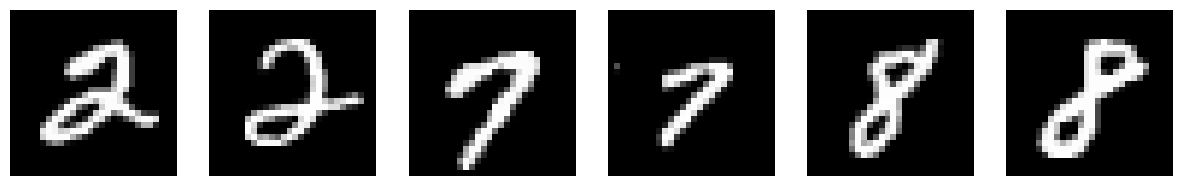

In [9]:
test_dataset = TinyMnistDataset(
    root=DATA_ROOT, train=True, keys=[2, 7, 8], num_images=2)
batch_size = len(test_dataset)

fig = plt.figure(figsize=(15, 6))
for i, image in enumerate(test_dataset):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(image, 'gray')
    plt.axis('off')

In [10]:
def calculate_anomaly_score(target_images, fake_images, D, lambda_weight=0.1):
    residual_loss = torch.abs(target_images - fake_images)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    _, t_feature = D(target_images)
    _, G_feature = D(fake_images)
    discrimination_loss = torch.abs(t_feature - G_feature)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    loss_each = (1-lambda_weight)*residual_loss + lambda_weight*discrimination_loss
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each

In [11]:
device = get_device()

transform=ImageTransform(MEAN, STD, image_size)
targets = torch.stack([transform(image) for image in test_dataset])
targets = targets.to(device)

z = torch.randn(batch_size, 20).to(device)
z.requires_grad = True
z_optimizer = torch.optim.Adam([z], lr=1e-3)

for epoch in range(5000):
    fake_images = G(z)
    loss, _ = calculate_anomaly_score(targets, fake_images, D)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}], loss: {loss.item():.0f}')

Epoch [1000], loss: 3513
Epoch [2000], loss: 2555
Epoch [3000], loss: 2272
Epoch [4000], loss: 1970
Epoch [5000], loss: 1856


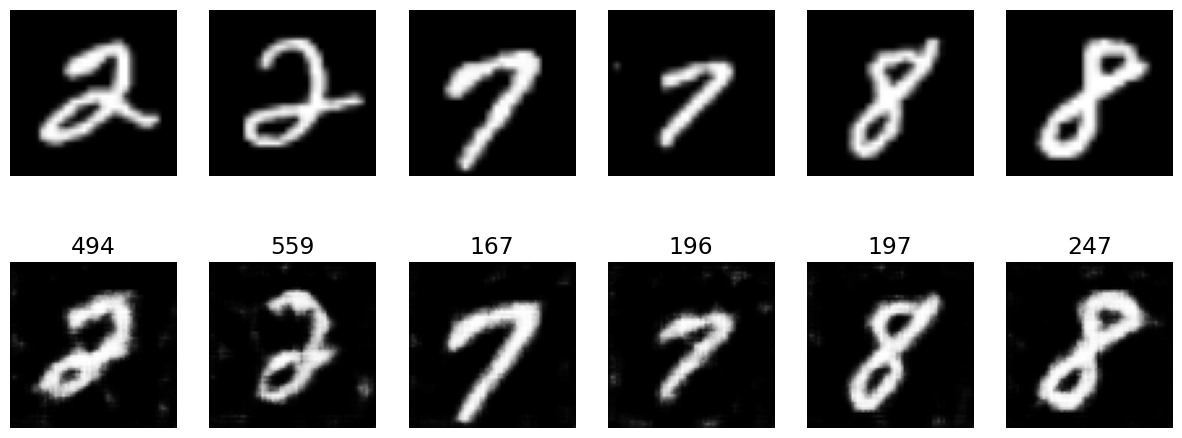

In [12]:
G.eval()
fake_images = G(z)

loss, loss_each = calculate_anomaly_score(targets, fake_images, D)
loss_each = loss_each.cpu().detach().numpy()

fig = plt.figure(figsize=(15, 6))
for i in range(batch_size):
    plt.subplot(2, batch_size, i+1)
    plt.imshow(targets[i][0].cpu().detach().numpy(), 'gray')
    plt.axis('off')

    plt.subplot(2, batch_size, batch_size+i+1)
    plt.title(f'{loss_each[i]:.0f}')
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    plt.axis('off')